In [ ]:
using_colab = True
if using_colab:
  from google.colab import drive
  drive.mount ('/content/gdrive', force_remount=True)
  !pip install rasterio rasterstats fiona geopandas earthpy -q
 # !pip install -q earthengine-api


Mounted at /content/gdrive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 13.6 MB/s eta 0:00:00


In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/ICRISAT/crop_type_classification')

In [ ]:
# Import necessary libraries
import ee
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import geemap
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import folium
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
# Authenticate to the Earth Engine servers
ee.Authenticate()
# Initialize the Earth Engine object with Google Cloud project ID
project_id = 'ee-janetmumo68'
ee.Initialize(project=project_id)


In [ ]:
# Function to load individual crop feature collections
def load_crop_data(asset_id):
    return ee.FeatureCollection(asset_id)

def to_polygon_or_multipolygon(feature):
    geom = feature.geometry()

    def handle_geometry(g):
        type = g.type()
        if type.equals('Polygon'):
            return g
        elif type.equals('MultiPolygon'):
            return g
        elif type.equals('GeometryCollection'):
            polygons = g.geometries().filter(ee.Filter.inList('type', ['Polygon', 'MultiPolygon']))
            return ee.Geometry.MultiPolygon(polygons)
        else:
            return None  # This will effectively remove any non-polygon geometries

    new_geom = handle_geometry(geom)
    return ee.Feature(new_geom, feature.toDictionary(feature.propertyNames()))

def remove_linestrings(feature):
    geom = feature.geometry()
    if geom.type() == 'LineString':
        return None
    else:
        return feature
# Load datasets from 2018-2020
data_2018 = ee.FeatureCollection("projects/ee-djitastar/assets/data_2018").map(to_polygon_or_multipolygon).map(remove_linestrings)#.filter(ee.Filter.notNull(['geometry']))
data_2019 = ee.FeatureCollection("projects/ee-djitastar/assets/data_2019").map(to_polygon_or_multipolygon).map(remove_linestrings)#.filter(ee.Filter.notNull(['geometry']))
data_2020 = ee.FeatureCollection("projects/ee-djitastar/assets/data_2020").map(to_polygon_or_multipolygon).map(remove_linestrings)#.filter(ee.Filter.notNull(['geometry']))
# Load the Senegal Admin1 boundaries
senegal_admin1 = ee.FeatureCollection("projects/ee-janet/assets/senegal/sen_adm1")

# Load individual rainfed 2023 crop feature collections
cashew = load_crop_data('projects/ee-kkidia3/assets/cashew')
cassava = load_crop_data('projects/ee-kkidia3/assets/cassava')
cowpea = load_crop_data('projects/ee-kkidia3/assets/cowpea')
cowpmix = load_crop_data('projects/ee-kkidia3/assets/cowpea_mixed')
eggplant = load_crop_data('projects/ee-kkidia3/assets/eggplant')
fallow = load_crop_data('projects/ee-kkidia3/assets/fallow')
fonio = load_crop_data('projects/ee-kkidia3/assets/fonio')
gnut = load_crop_data('projects/ee-kkidia3/assets/groundnut')
gnutmix = load_crop_data('projects/ee-kkidia3/assets/groundnut_mixed')
gsorrel = load_crop_data('projects/ee-kkidia3/assets/guinea_sorrel')
maize = load_crop_data('projects/ee-kkidia3/assets/maize')
millet = load_crop_data('projects/ee-kkidia3/assets/millet')
milletmix = load_crop_data('projects/ee-kkidia3/assets/millet_mixed')
okra = load_crop_data('projects/ee-kkidia3/assets/okra')
potato = load_crop_data('projects/ee-kkidia3/assets/potato')
rice = load_crop_data('projects/ee-kkidia3/assets/rice')
sesame = load_crop_data('projects/ee-kkidia3/assets/sesame')
sorgh = load_crop_data('projects/ee-kkidia3/assets/sorghum')
soye = load_crop_data('projects/ee-kkidia3/assets/soye')
squash = load_crop_data('projects/ee-kkidia3/assets/squash')
taro = load_crop_data('projects/ee-kkidia3/assets/taro')
vouandzou = load_crop_data('projects/ee-kkidia3/assets/vouandzou')
melon = load_crop_data('projects/ee-kkidia3/assets/watermelon')
wheat = load_crop_data('projects/ee-kkidia3/assets/wheat')


# Merge datasets
merged18_20 = data_2018.merge(data_2019).merge(data_2020)

# Merge all crop fields into a single feature collection
merged2023 = gnut.merge(gsorrel).merge(cashew).merge(cassava).merge(cowpea).merge(cowpmix)\
                .merge(eggplant).merge(fallow).merge(fonio).merge(gnutmix).merge(gsorrel)\
                .merge(maize).merge(millet).merge(milletmix).merge(okra).merge(potato)\
                .merge(rice).merge(sesame).merge(sorgh).merge(soye).merge(squash).merge(taro)\
                .merge(vouandzou).merge(melon).merge(wheat).map(remove_linestrings)

In [ ]:
# Function to load individual crop feature collections
def load_crop_data(asset_id):
    return ee.FeatureCollection(asset_id)

# Function to filter out LineString geometries
def remove_linestrings(feature):
    return ee.Algorithms.If(
        ee.Algorithms.IsEqual(feature.geometry().type(), 'LineString'),
        None,
        feature
    )
# Load datasets from 2018-2020
data_2018 = ee.FeatureCollection("projects/ee-djitastar/assets/data_2018").map(remove_linestrings)
data_2019 = ee.FeatureCollection("projects/ee-djitastar/assets/data_2019").map(remove_linestrings)
data_2020 = ee.FeatureCollection("projects/ee-djitastar/assets/data_2020").map(remove_linestrings)
# Load the Senegal Admin1 boundaries
senegal_admin1 = ee.FeatureCollection("projects/ee-janet/assets/senegal/sen_adm1")

# Load individual rainfed 2023 crop feature collections
cashew = load_crop_data('projects/ee-kkidia3/assets/cashew')
cassava = load_crop_data('projects/ee-kkidia3/assets/cassava')
cowpea = load_crop_data('projects/ee-kkidia3/assets/cowpea')
cowpmix = load_crop_data('projects/ee-kkidia3/assets/cowpea_mixed')
eggplant = load_crop_data('projects/ee-kkidia3/assets/eggplant')
fallow = load_crop_data('projects/ee-kkidia3/assets/fallow')
fonio = load_crop_data('projects/ee-kkidia3/assets/fonio')
gnut = load_crop_data('projects/ee-kkidia3/assets/groundnut')
gnutmix = load_crop_data('projects/ee-kkidia3/assets/groundnut_mixed')
gsorrel = load_crop_data('projects/ee-kkidia3/assets/guinea_sorrel')
maize = load_crop_data('projects/ee-kkidia3/assets/maize')
millet = load_crop_data('projects/ee-kkidia3/assets/millet')
milletmix = load_crop_data('projects/ee-kkidia3/assets/millet_mixed')
okra = load_crop_data('projects/ee-kkidia3/assets/okra')
potato = load_crop_data('projects/ee-kkidia3/assets/potato')
rice = load_crop_data('projects/ee-kkidia3/assets/rice')
sesame = load_crop_data('projects/ee-kkidia3/assets/sesame')
sorgh = load_crop_data('projects/ee-kkidia3/assets/sorghum')
soye = load_crop_data('projects/ee-kkidia3/assets/soye')
squash = load_crop_data('projects/ee-kkidia3/assets/squash')
taro = load_crop_data('projects/ee-kkidia3/assets/taro')
vouandzou = load_crop_data('projects/ee-kkidia3/assets/vouandzou')
melon = load_crop_data('projects/ee-kkidia3/assets/watermelon')
wheat = load_crop_data('projects/ee-kkidia3/assets/wheat')


# Merge datasets
merged18_20 = data_2018.merge(data_2019).merge(data_2020)

# Merge all crop fields into a single feature collection
merged2023 = gnut.merge(gsorrel).merge(cashew).merge(cassava).merge(cowpea).merge(cowpmix)\
                .merge(eggplant).merge(fallow).merge(fonio).merge(gnutmix).merge(gsorrel)\
                .merge(maize).merge(millet).merge(milletmix).merge(okra).merge(potato)\
                .merge(rice).merge(sesame).merge(sorgh).merge(soye).merge(squash).merge(taro)\
                .merge(vouandzou).merge(melon).merge(wheat).map(remove_linestrings)

Show dataframe and identify non-crop categories in this datasets

In [ ]:
# Get the first 1000 features (adjust this number based on your needs and system capabilities)
features_to_display = data_2020.limit(5000).getInfo()['features']

# Extract properties into a list of dictionaries
properties_list = [feature['properties'] for feature in features_to_display]

# Create a DataFrame from the properties list
df = pd.DataFrame(properties_list)
df.head()


,Admin0,Admin1,Admin2,Admin3,Admin4,Annee,Collect_Pe,Crop_Ncrop,Id_1,Observatio,Site,SourceD,Speculatio,Sup_ha,Type,id
0,Senegal,Matam,Kanel,Kanel,Kanel,2020,22 Aout au 1er Septembre,Crop,0,,,CSE/SERVIR,Mixte (mil nieb,0.507473,,00000000000000006283
1,Senegal,Matam,Kanel,Kanel,Kanel,2020,22 Aout au 1er Septembre,Crop,0,,,CSE/SERVIR,Mixte (mil nieb,0.993971,,00000000000000006289
2,Senegal,Matam,Kanel,Kanel,Kanel,2020,22 Aout au 1er Septembre,Crop,0,,,CSE/SERVIR,Mixte (mil biss,0.325075,,0000000000000000628a
3,Senegal,Matam,Kanel,Kanel,Kanel,2020,22 Aout au 1er Septembre,Crop,0,,,CSE/SERVIR,Groundnut_mixed,0.557906,,0000000000000000628b
4,Senegal,Matam,Kanel,Kanel,Kanel,2020,22 Aout au 1er Septembre,Crop,0,,,CSE/SERVIR,Mixte (mil nieb,0.740876,,0000000000000000628e


In [ ]:
df.tail()

,Admin0,Admin1,Admin2,Admin3,Admin4,Annee,Collect_Pe,Crop_Ncrop,Id_1,Observatio,Site,SourceD,Speculatio,Sup_ha,Type,id
4995,Senegal,Tambacounda,Tambacounda,Missirah,Missirah,2020,22 Aout au 1er Septembre,Crop,0,,Missirah,CSE/SERVIR,Groundnut,1.397953,,000000000000000061d1
4996,Senegal,Tambacounda,Tambacounda,Missirah,Missirah,2020,22 Aout au 1er Septembre,Crop,0,,Missirah,CSE/SERVIR,Groundnut,0.659094,,000000000000000061d2
4997,Senegal,Tambacounda,Tambacounda,Missirah,Missirah,2020,22 Aout au 1er Septembre,Crop,0,,Missirah,CSE/SERVIR,Groundnut,0.694127,,000000000000000061d3
4998,Senegal,Tambacounda,Tambacounda,Missirah,Missirah,2020,22 Aout au 1er Septembre,Crop,0,,Missirah,CSE/SERVIR,Groundnut,0.213285,,000000000000000061d5
4999,Senegal,Tambacounda,Tambacounda,Missirah,Missirah,2020,22 Aout au 1er Septembre,Crop,0,,Missirah,CSE/SERVIR,Groundnut,0.705839,,000000000000000061d6


# Phenology dynamics

Phenology dynamics refers to the study of periodic biological events in plants and animals as influenced by seasonal and inter-annual variations in climate and habitat factors

Key aspects of crop phenology:

Germination
Leaf emergence
Flowering
Fruit development
Senescence (aging and death of plant parts)


Importance in agriculture:

Understanding crop phenology helps in optimizing farming practices such as planting dates, irrigation scheduling, and harvest timing.
It's crucial for crop yield prediction and management.


Remote sensing and phenology:

Satellite-based vegetation indices like NDVI (Normalized Difference Vegetation Index) are often used to track phenology dynamics.
These indices can show changes in vegetation greenness over time, which correlate with different growth stages.


Phenology metrics:

Start of Season (SOS): When plant growth begins
Peak of Season (POS): When vegetation reaches maximum greenness
End of Season (EOS): When plants senesce or are harvested
Length of Season (LOS): Duration between SOS and EOS

## Evaluating the separability of crops

1.   Evaluate the plot of NDVI  for each crop in each region
2.   Compare the NDVI for each crop in all regions



In [ ]:
data_2018.getInfo()

In [ ]:
admni_properties = data_2018.aggregate_array('Admin1').getInfo()
uniqueNames = ee.List(admni_properties).distinct().getInfo()
print(uniqueNames)
Fatick = data_2018.filter(ee.Filter.eq('Admin1', 'Fatick'))


['Fatick', 'Thies', 'Tambacounda', 'Diourbel', 'Kaolack']


Unique Admin1 regions: ['Fatick', 'Thies', 'Tambacounda', 'Diourbel', 'Kaolack']


Processing Admin1 region: Fatick
Crops in this region: ['Rice', 'Millet', 'Sorghum', 'Groundnut', 'Bean', 'Cowpea', 'Maize', 'Mango tree', 'Onion', 'Tomato', 'Leguminous', 'Fruit crop', 'Citrus tree']
Error occurred. Retrying in 1 seconds...
An error occurred for Fatick: name 'time' is not defined
Skipping this region and continuing with the next.

--------------------------------------------------

Processing Admin1 region: Thies
Crops in this region: ['Millet', 'Sorghum', 'Groundnut', 'Eggplant', 'Sweet potato', 'Potato', 'Tomato', 'Citrus tree', 'Fruit crop', 'Leguminous', 'Mango tree', 'Cowpea', 'Cassava', 'Cabbage', 'Bean']
Error occurred. Retrying in 1 seconds...
An error occurred for Thies: name 'time' is not defined
Skipping this region and continuing with the next.

--------------------------------------------------

Processing Admin1 region: Tambacounda
Crops in this region: ['Maize', 'Mango tr

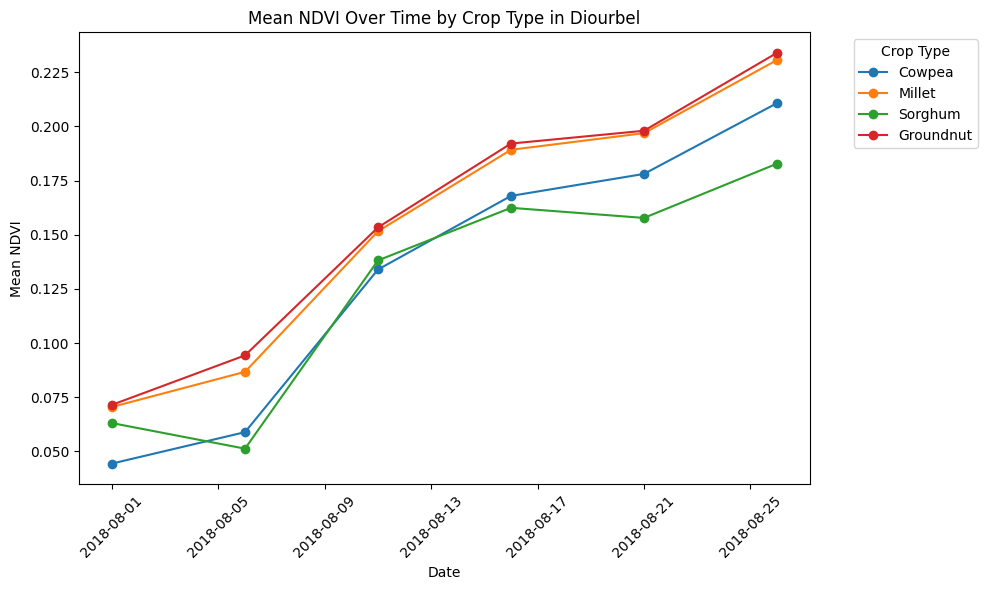

NDVI time series plot for all crops in Diourbel displayed.

--------------------------------------------------

Processing Admin1 region: Kaolack
Crops in this region: ['Maize', 'Millet', 'Groundnut', 'Watermelon', 'Sesame']


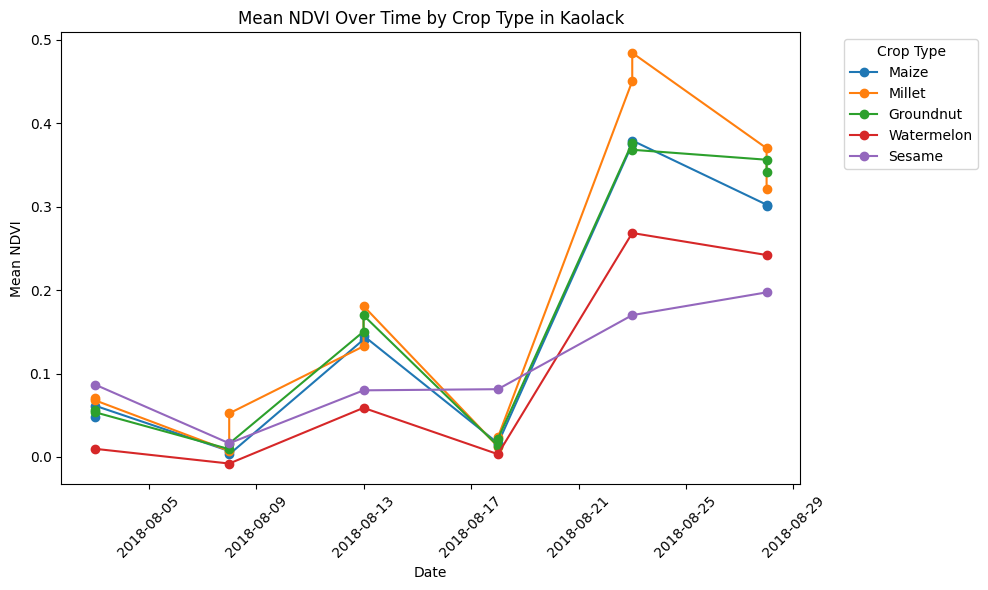

NDVI time series plot for all crops in Kaolack displayed.

--------------------------------------------------

Processing complete. All plots have been displayed.


In [ ]:
# Get unique Admin1 regions
admin_properties = data_2018.aggregate_array('Admin1').distinct()
unique_admin1 = admin_properties.getInfo()

print("Unique Admin1 regions:", unique_admin1)
print("\n" + "="*50 + "\n")
# Function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Function to safely execute Earth Engine operations with retries
def ee_safe_execute(func, max_retries=5, initial_wait=1):
    for attempt in range(max_retries):
        try:
            return func()
        except Exception as e:
            if attempt == max_retries - 1:
                raise e
            wait_time = initial_wait * (2 ** attempt)
            print(f"Error occurred. Retrying in {wait_time} seconds...")
            time.sleep(wait_time)

# Loop through each Admin1 region
for admin1 in unique_admin1:
    print(f"Processing Admin1 region: {admin1}")

    # Filter data_2018 for the current Admin1 region
    current_data = data_2018.filter(ee.Filter.eq('Admin1', admin1))

    # Get unique crops in this Admin1 region
    crops = ee_safe_execute(lambda: current_data.aggregate_array('Speculatio').distinct().getInfo())
    crops = [crop for crop in crops if crop != '']  # Remove empty crop names
    print(f"Crops in this region: {crops}")

    try:
        # Load Sentinel-2 imagery and filter by date and bounds of the polygons
        sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
            .filterBounds(current_data) \
            .filterDate('2018-08-01', '2018-08-30') \
            .map(calculate_ndvi)

        # Function to calculate mean NDVI for all crop types in an image
        def calculate_mean_ndvi_all_crops(image):
            def crop_ndvi(crop):
                crop_data = current_data.filter(ee.Filter.eq('Speculatio', crop))
                mean = image.select('NDVI').reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=crop_data.geometry(),
                    scale=10,
                    maxPixels=1e9
                )
                return ee.Feature(None, {
                    'crop': crop,
                    'mean_ndvi': mean.get('NDVI'),
                    'date': image.date().format('YYYY-MM-dd')
                })

            return ee.FeatureCollection(ee.List(crops).map(lambda crop: crop_ndvi(crop)))

        # Calculate mean NDVI for each image and crop
        ndvi_time_series = sentinel2.map(calculate_mean_ndvi_all_crops).flatten()

        # Get the time series data
        time_series_data = ee_safe_execute(lambda: ndvi_time_series.getInfo())

        # Convert to pandas DataFrame
        df_list = []
        for feature in time_series_data['features']:
            props = feature['properties']
            if 'mean_ndvi' in props and props['mean_ndvi'] is not None:
                df_list.append({
                    'date': props['date'],
                    'crop': props['crop'],
                    'mean_ndvi': props['mean_ndvi']
                })

        if not df_list:
            print(f"No valid NDVI data found for {admin1}")
            continue

        df_time_series = pd.DataFrame(df_list)
        df_time_series['date'] = pd.to_datetime(df_time_series['date'])
        df_time_series = df_time_series.sort_values('date')

        # Create a line plot for all crops
        plt.figure(figsize=(10, 6))

        for crop in crops:
            crop_data = df_time_series[df_time_series['crop'] == crop]
            if not crop_data.empty:
                plt.plot(crop_data['date'], crop_data['mean_ndvi'], marker='o', label=crop)

        plt.title(f'Mean NDVI Over Time by Crop Type in {admin1}')
        plt.xlabel('Date')
        plt.ylabel('Mean NDVI')
        plt.xticks(rotation=45)
        plt.legend(title='Crop Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        print(f"NDVI time series plot for all crops in {admin1} displayed.")

    except Exception as e:
        print(f"An error occurred for {admin1}: {str(e)}")
        print("Skipping this region and continuing with the next.")

    print("\n" + "-"*50 + "\n")

print("Processing complete. All plots have been displayed.")

In [ ]:
# Function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Function to add Earth Engine layer to Folium map
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

# Load the Senegal Admin1 boundaries
senegal_admin1 = ee.FeatureCollection("projects/ee-janet/assets/senegal/sen_adm1")

# Get the center of Senegal for the map
center = senegal_admin1.geometry().centroid().getInfo()['coordinates']
m = folium.Map(location=[center[1], center[0]], zoom_start=7)

# Get unique Admin1 names
unique_admin1 = senegal_admin1.aggregate_array('ADM1_EN').distinct().getInfo()
sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(senegal_admin1) \
    .filterDate('2023-01-01', '2023-12-31') \
    .map(calculate_ndvi)

# Compute median composite
ndvi_median = sentinel2.select('NDVI').max().clip(senegal_admin1)

# Visualization parameters for NDVI
ndvi_vis = {
    'min': -1,
    'max': 1,
    'palette': ['blue', 'red', 'yellow', 'lightgreen', 'darkgreen']
}
area ='senegal'
# Add NDVI layer to the map
m.add_ee_layer(ndvi_median, ndvi_vis, f'NDVI_max - {area}')

# Map NDVI values using thresholds
ndvi_mapped = ee.Image(1) \
    .where(ndvi_median.lte(-0.1), 1) \
    .where(ndvi_median.gt(-0.1).And(ndvi_median.lte(-0.2)), 2) \
    .where(ndvi_median.gt(-0.2).And(ndvi_median.lte(0)), 3) \
    .where(ndvi_median.gt(0).And(ndvi_median.lte(0.1)), 4) \
    .where(ndvi_median.gt(0.1).And(ndvi_median.lte(0.2)), 5) \
    .where(ndvi_median.gt(0.2).And(ndvi_median.lte(0.4)), 6) \
    .where(ndvi_median.gt(0.4), 7)



ndvi_map_vis = {
    'min': 1,
    'max': 7,
    'palette': ['white','grey','blue', 'red', 'yellow', 'lightgreen', 'darkgreen']
}

# Add mapped NDVI layer to the map
m.add_ee_layer(ndvi_mapped, ndvi_map_vis, f'NDVI Mapped_max - {area}')

# Add region boundaries
style_function = lambda x: {'fillColor': '#00000000', 'color': '#000000', 'weight': 2}
folium.GeoJson(senegal_admin1.getInfo(), style_function=style_function, name="Admin1 Boundaries").add_to(m)
folium.GeoJson(data_2018.getInfo(), style_function=style_function, name="2018_crops").add_to(m)
# Add layer control
folium.LayerControl().add_to(m)

# Display the map
m

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Function to add Earth Engine layer to Folium map
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

# Load the Senegal Admin1 boundaries
senegal_admin1 = ee.FeatureCollection("projects/ee-janet/assets/senegal/sen_adm1")

# Get the center of Senegal for the map
center = senegal_admin1.geometry().centroid().getInfo()['coordinates']
m = folium.Map(location=[center[1], center[0]], zoom_start=7)

# Months to process
months = ['08', '09', '10', '11']
month_names = ['August', 'September', 'October', 'November']

# Visualization parameters for NDVI
ndvi_vis = {
    'min': -1,
    'max': 1,
    'palette': ['blue', 'red', 'yellow', 'lightgreen', 'darkgreen']
}

ndvi_map_vis = {
    'min': 1,
    'max': 7,
    'palette': ['white','blue','grey', 'red', 'yellow', 'lightgreen', 'darkgreen']
}

for month, month_name in zip(months, month_names):
    start_date = f'2023-{month}-01'
    end_date = f'2023-{month}-30'  # Using 30 for all months for simplicity

    sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(senegal_admin1) \
        .filterDate(start_date, end_date) \
        .map(calculate_ndvi)

    # Compute median composite
    ndvi_median = sentinel2.select('NDVI').median().clip(senegal_admin1)

    # Add NDVI layer to the map
    m.add_ee_layer(ndvi_median, ndvi_vis, f'NDVI - {month_name}')

    # Map NDVI values using thresholds
    ndvi_mapped = ee.Image(1) \
        .where(ndvi_median.lte(-0.1), 1) \
        .where(ndvi_median.gt(-0.1).And(ndvi_median.lte(-0.2)), 2) \
        .where(ndvi_median.gt(-0.2).And(ndvi_median.lte(0)), 3) \
        .where(ndvi_median.gt(0).And(ndvi_median.lte(0.1)), 4) \
        .where(ndvi_median.gt(0.1).And(ndvi_median.lte(0.2)), 5) \
        .where(ndvi_median.gt(0.2).And(ndvi_median.lte(0.4)), 6) \
        .where(ndvi_median.gt(0.4), 7)

    # Add mapped NDVI layer to the map
    m.add_ee_layer(ndvi_mapped, ndvi_map_vis, f'NDVI Mapped - {month_name}')

    print(f"NDVI layers added for {month_name}")

# Add region boundaries
style_function = lambda x: {'fillColor': '#00000000', 'color': '#000000', 'weight': 2}
folium.GeoJson(senegal_admin1.getInfo(), style_function=style_function, name="Admin1 Boundaries").add_to(m)
folium.GeoJson(data_2018.getInfo(), style_function=style_function, name="2018_crops").add_to(m)
# Add layer control
folium.LayerControl().add_to(m)

# Display the map
m

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import ee
import folium
from folium import TileLayer

# Initialize Earth Engine
ee.Initialize()

def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Function to add Earth Engine layer to Folium map
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

# Load the Senegal Admin1 boundaries
senegal_admin1 = ee.FeatureCollection("projects/ee-janet/assets/senegal/sen_adm1")

# Get the center of Senegal for the map
center = senegal_admin1.geometry().centroid().getInfo()['coordinates']

# Create the map with satellite imagery as the base layer
m = folium.Map(location=[center[1], center[0]], zoom_start=7, tiles=None)

# Add Google Satellite base layer
TileLayer(
    tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google Satellite',
    name='Google Satellite',
    overlay=False,
    control=True
).add_to(m)

# Add OpenStreetMap as an optional base layer
TileLayer(
    tiles='https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
    attr='OpenStreetMap',
    name='OpenStreetMap',
    overlay=False,
    control=True
).add_to(m)

# Months to process
months = ['08', '09', '10', '11']
month_names = ['August', 'September', 'October', 'November']

# Visualization parameters for NDVI
ndvi_vis = {
    'min': -1,
    'max': 1,
    'palette': ['blue', 'red', 'yellow', 'lightgreen', 'darkgreen']
}

ndvi_map_vis = {
    'min': 1,
    'max': 7,
    'palette': ['white','blue','grey', 'red', 'yellow', 'lightgreen', 'darkgreen']
}

for month, month_name in zip(months, month_names):
    start_date = f'2023-{month}-01'
    end_date = f'2023-{month}-30'  # Using 30 for all months for simplicity

    sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(senegal_admin1) \
        .filterDate(start_date, end_date) \
        .map(calculate_ndvi)

    # Compute median composite
    ndvi_median = sentinel2.select('NDVI').median().clip(senegal_admin1)

    # Add NDVI layer to the map
    m.add_ee_layer(ndvi_median, ndvi_vis, f'NDVI - {month_name}')

    # Map NDVI values using thresholds
    ndvi_mapped = ee.Image(1) \
        .where(ndvi_median.lte(-0.1), 1) \
        .where(ndvi_median.gt(-0.1).And(ndvi_median.lte(-0.2)), 2) \
        .where(ndvi_median.gt(-0.2).And(ndvi_median.lte(0)), 3) \
        .where(ndvi_median.gt(0).And(ndvi_median.lte(0.1)), 4) \
        .where(ndvi_median.gt(0.1).And(ndvi_median.lte(0.2)), 5) \
        .where(ndvi_median.gt(0.2).And(ndvi_median.lte(0.4)), 6) \
        .where(ndvi_median.gt(0.4), 7)

    # Add mapped NDVI layer to the map
    m.add_ee_layer(ndvi_mapped, ndvi_map_vis, f'NDVI Mapped - {month_name}')

    print(f"NDVI layers added for {month_name}")

# Add region boundaries
style_function = lambda x: {'fillColor': '#00000000', 'color': '#000000', 'weight': 2}
folium.GeoJson(senegal_admin1.getInfo(), style_function=style_function, name="Admin1 Boundaries").add_to(m)
folium.GeoJson(data_2018.getInfo(), style_function=style_function, name="2018_crops").add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Display the map
m

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import ee
import folium
from folium import TileLayer
import random

# Initialize Earth Engine
ee.Initialize()

def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Function to add Earth Engine layer to Folium map
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

# Load the Senegal Admin1 boundaries
senegal_admin1 = ee.FeatureCollection("projects/ee-janet/assets/senegal/sen_adm1")

# Get the center of Senegal for the map
center = senegal_admin1.geometry().centroid().getInfo()['coordinates']

# Create the map with satellite imagery as the base layer
m = folium.Map(location=[center[1], center[0]], zoom_start=7, tiles=None)

# Add Google Satellite base layer
TileLayer(
    tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google Satellite',
    name='Google Satellite',
    overlay=False,
    control=True
).add_to(m)

# Add OpenStreetMap as an optional base layer
TileLayer(
    tiles='https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
    attr='OpenStreetMap',
    name='OpenStreetMap',
    overlay=False,
    control=True
).add_to(m)

# Months to process
months = ['08', '09', '10', '11']
month_names = ['August', 'September', 'October', 'November']

# Visualization parameters for NDVI
ndvi_vis = {
    'min': -1,
    'max': 1,
    'palette': ['blue', 'red', 'yellow', 'lightgreen', 'darkgreen']
}

ndvi_map_vis = {
    'min': 1,
    'max': 7,
    'palette': ['white','blue','grey', 'red', 'yellow', 'lightgreen', 'darkgreen']
}

for month, month_name in zip(months, month_names):
    start_date = f'2018-{month}-01'
    end_date = f'2018-{month}-30'  # Using 30 for all months for simplicity

    sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(senegal_admin1) \
        .filterDate(start_date, end_date) \
        .map(calculate_ndvi)

    # Compute median composite
    ndvi_median = sentinel2.select('NDVI').median().clip(senegal_admin1)

    # Add NDVI layer to the map
    m.add_ee_layer(ndvi_median, ndvi_vis, f'NDVI - {month_name}')

    # Map NDVI values using thresholds
    ndvi_mapped = ee.Image(1) \
        .where(ndvi_median.lte(-0.1), 1) \
        .where(ndvi_median.gt(-0.1).And(ndvi_median.lte(-0.2)), 2) \
        .where(ndvi_median.gt(-0.2).And(ndvi_median.lte(0)), 3) \
        .where(ndvi_median.gt(0).And(ndvi_median.lte(0.1)), 4) \
        .where(ndvi_median.gt(0.1).And(ndvi_median.lte(0.2)), 5) \
        .where(ndvi_median.gt(0.2).And(ndvi_median.lte(0.4)), 6) \
        .where(ndvi_median.gt(0.4), 7)

    # Add mapped NDVI layer to the map
    m.add_ee_layer(ndvi_mapped, ndvi_map_vis, f'NDVI Mapped - {month_name}')

    print(f"NDVI layers added for {month_name}")

# Add region boundaries
style_function = lambda x: {'fillColor': '#00000000', 'color': '#000000', 'weight': 2}
folium.GeoJson(senegal_admin1.getInfo(), style_function=style_function, name="Admin1 Boundaries").add_to(m)

# Get unique crop types from data_2018
crop_types = list(set([feature['properties']['Speculatio'] for feature in data_2018.getInfo()['features'] if 'Speculatio' in feature['properties']]))

# Generate a color for each crop type
color_map = {crop: f'#{random.randint(0, 0xFFFFFF):06x}' for crop in crop_types}

# Function to style each feature based on its crop type
def style_function(feature):
    crop = feature['properties'].get('Speculatio', '')
    return {
        'fillColor': color_map.get(crop, '#FFFFFF'),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7
    }

# Add 2018 crops layer with different colors for each crop type
folium.GeoJson(
    data_2018.getInfo(),
    style_function=style_function,
    name="2018 Crops"
).add_to(m)

# Add a legend for crop types
legend_html = '''
    <div style="position: fixed; bottom: 50px; left: 50px; width: 220px; height: 280px;
    border:2px solid grey; z-index:9999; font-size:14px; background-color:white;
    overflow-y: auto;">
    <div style="padding: 10px;">
    <strong>Crop Types</strong><br>
    '''
for crop, color in color_map.items():
    legend_html += f'<span style="background-color: {color}; border: 1px solid black; display: inline-block; width: 12px; height: 12px;"></span> {crop}<br>'
legend_html += '</div></div>'

m.get_root().html.add_child(folium.Element(legend_html))

# Add layer control
folium.LayerControl().add_to(m)

# Display the map
m

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import ee
import folium
from folium import TileLayer
import random

# Initialize Earth Engine
ee.Initialize()

def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Function to add Earth Engine layer to Folium map
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

# Load the Senegal Admin1 boundaries
senegal_admin1 = ee.FeatureCollection("projects/ee-janet/assets/senegal/sen_adm1")

# Get the center of Senegal for the map
center = senegal_admin1.geometry().centroid().getInfo()['coordinates']

# Create the map with satellite imagery as the base layer
m = folium.Map(location=[center[1], center[0]], zoom_start=7, tiles=None)

# Add Google Satellite base layer
TileLayer(
    tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google Satellite',
    name='Google Satellite',
    overlay=False,
    control=True
).add_to(m)

# Add OpenStreetMap as an optional base layer
TileLayer(
    tiles='https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
    attr='OpenStreetMap',
    name='OpenStreetMap',
    overlay=False,
    control=True
).add_to(m)

# Create RGB composite for 2018
sentinel_2018 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(senegal_admin1) \
    .filterDate('2018-01-01', '2018-12-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

rgb_2018 = sentinel_2018.median().clip(senegal_admin1)

rgb_vis_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2']
}

# Add RGB composite to the map
m.add_ee_layer(rgb_2018, rgb_vis_params, 'RGB Composite 2018')

# Months to process
months = ['08', '09', '10', '11']
month_names = ['August', 'September', 'October', 'November']

# Visualization parameters for NDVI
ndvi_vis = {
    'min': -1,
    'max': 1,
    'palette': ['blue', 'red', 'yellow', 'lightgreen', 'darkgreen']
}

ndvi_map_vis = {
    'min': 1,
    'max': 7,
    'palette': ['white','blue','grey', 'red', 'yellow', 'lightgreen', 'darkgreen']
}

for month, month_name in zip(months, month_names):
    start_date = f'2023-{month}-01'
    end_date = f'2023-{month}-30'  # Using 30 for all months for simplicity

    sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(senegal_admin1) \
        .filterDate(start_date, end_date) \
        .map(calculate_ndvi)

    # Compute median composite
    ndvi_median = sentinel2.select('NDVI').median().clip(senegal_admin1)

    # Add NDVI layer to the map
    m.add_ee_layer(ndvi_median, ndvi_vis, f'NDVI - {month_name}')

    # Map NDVI values using thresholds
    ndvi_mapped = ee.Image(1) \
        .where(ndvi_median.lte(-0.1), 1) \
        .where(ndvi_median.gt(-0.1).And(ndvi_median.lte(-0.2)), 2) \
        .where(ndvi_median.gt(-0.2).And(ndvi_median.lte(0)), 3) \
        .where(ndvi_median.gt(0).And(ndvi_median.lte(0.1)), 4) \
        .where(ndvi_median.gt(0.1).And(ndvi_median.lte(0.2)), 5) \
        .where(ndvi_median.gt(0.2).And(ndvi_median.lte(0.4)), 6) \
        .where(ndvi_median.gt(0.4), 7)

    # Add mapped NDVI layer to the map
    m.add_ee_layer(ndvi_mapped, ndvi_map_vis, f'NDVI Mapped - {month_name}')

    print(f"NDVI layers added for {month_name}")

# Add region boundaries
style_function = lambda x: {'fillColor': '#00000000', 'color': '#000000', 'weight': 2}
folium.GeoJson(senegal_admin1.getInfo(), style_function=style_function, name="Admin1 Boundaries").add_to(m)

# Get unique crop types from data_2018
crop_types = list(set([feature['properties']['Speculatio'] for feature in data_2018.getInfo()['features'] if 'Speculatio' in feature['properties']]))

# Generate a color for each crop type
color_map = {crop: f'#{random.randint(0, 0xFFFFFF):06x}' for crop in crop_types}

# Function to style each feature based on its crop type
def style_function(feature):
    crop = feature['properties'].get('Speculatio', '')
    return {
        'fillColor': color_map.get(crop, '#FFFFFF'),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7
    }

# Add 2018 crops layer with different colors for each crop type
folium.GeoJson(
    data_2018.getInfo(),
    style_function=style_function,
    name="2018 Crops"
).add_to(m)

# Add a legend for crop types
legend_html = '''
    <div style="position: fixed; bottom: 50px; left: 50px; width: 220px; height: 280px;
    border:2px solid grey; z-index:9999; font-size:14px; background-color:white;
    overflow-y: auto;">
    <div style="padding: 10px;">
    <strong>Crop Types</strong><br>
    '''
for crop, color in color_map.items():
    legend_html += f'<span style="background-color: {color}; border: 1px solid black; display: inline-block; width: 12px; height: 12px;"></span> {crop}<br>'
legend_html += '</div></div>'

m.get_root().html.add_child(folium.Element(legend_html))

# Add layer control
folium.LayerControl().add_to(m)

# Display the map
m

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import ee
import folium
from folium import TileLayer
import random

# Initialize Earth Engine
ee.Initialize()

def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Function to add Earth Engine layer to Folium map
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

# Load the Senegal Admin1 boundaries
senegal_admin1 = ee.FeatureCollection("projects/ee-janet/assets/senegal/sen_adm1")

# Filter out rows with empty or space-only crop names from data_2018
data_2018_filtered = data_2018.filter(ee.Filter.notNull(['Speculatio']))
data_2018_filtered = data_2018_filtered.filter(ee.Filter.neq('Speculatio', ''))
data_2018_filtered = data_2018_filtered.filter(ee.Filter.neq('Speculatio', ' '))

# Get the center of Senegal for the map
center = senegal_admin1.geometry().centroid().getInfo()['coordinates']

# Create the map with satellite imagery as the base layer
m = folium.Map(location=[center[1], center[0]], zoom_start=7, tiles=None)

# Add Google Satellite base layer
TileLayer(
    tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google Satellite',
    name='Google Satellite',
    overlay=False,
    control=True
).add_to(m)

# Add OpenStreetMap as an optional base layer
TileLayer(
    tiles='https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
    attr='OpenStreetMap',
    name='OpenStreetMap',
    overlay=False,
    control=True
).add_to(m)

# Create RGB composite for 2018
sentinel_2018 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(senegal_admin1) \
    .filterDate('2018-01-01', '2018-12-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

rgb_2018 = sentinel_2018.median().clip(senegal_admin1)

rgb_vis_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2']
}

# Add RGB composite to the map
m.add_ee_layer(rgb_2018, rgb_vis_params, 'RGB Composite 2018')

# Months to process
months = ['08', '09', '10', '11']
month_names = ['August', 'September', 'October', 'November']

# Visualization parameters for NDVI
ndvi_vis = {
    'min': -1,
    'max': 1,
    'palette': ['blue', 'red', 'yellow', 'lightgreen', 'darkgreen']
}

ndvi_map_vis = {
    'min': 1,
    'max': 7,
    'palette': ['white','blue','grey', 'red', 'yellow', 'lightgreen', 'darkgreen']
}

for month, month_name in zip(months, month_names):
    start_date = f'2023-{month}-01'
    end_date = f'2023-{month}-30'  # Using 30 for all months for simplicity

    sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(senegal_admin1) \
        .filterDate(start_date, end_date) \
        .map(calculate_ndvi)

    # Compute median composite
    ndvi_median = sentinel2.select('NDVI').median().clip(senegal_admin1)

    # Add NDVI layer to the map
    m.add_ee_layer(ndvi_median, ndvi_vis, f'NDVI - {month_name}')

    # Map NDVI values using thresholds
    ndvi_mapped = ee.Image(1) \
        .where(ndvi_median.lte(-0.1), 1) \
        .where(ndvi_median.gt(-0.1).And(ndvi_median.lte(-0.2)), 2) \
        .where(ndvi_median.gt(-0.2).And(ndvi_median.lte(0)), 3) \
        .where(ndvi_median.gt(0).And(ndvi_median.lte(0.1)), 4) \
        .where(ndvi_median.gt(0.1).And(ndvi_median.lte(0.2)), 5) \
        .where(ndvi_median.gt(0.2).And(ndvi_median.lte(0.4)), 6) \
        .where(ndvi_median.gt(0.4), 7)

    # Add mapped NDVI layer to the map
    m.add_ee_layer(ndvi_mapped, ndvi_map_vis, f'NDVI Mapped - {month_name}')

    print(f"NDVI layers added for {month_name}")

# Add region boundaries
style_function = lambda x: {'fillColor': '#00000000', 'color': '#000000', 'weight': 2}
folium.GeoJson(senegal_admin1.getInfo(), style_function=style_function, name="Admin1 Boundaries").add_to(m)

# Get unique crop types from filtered data_2018
crop_types = list(set([feature['properties']['Speculatio'] for feature in data_2018_filtered.getInfo()['features']]))

# Generate a color for each crop type
color_map = {crop: f'#{random.randint(0, 0xFFFFFF):06x}' for crop in crop_types}

# Function to style each feature based on its crop type
def style_function(feature):
    crop = feature['properties'].get('Speculatio', '')
    return {
        'fillColor': color_map.get(crop, '#FFFFFF'),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7
    }

# Add filtered 2018 crops layer with different colors for each crop type
folium.GeoJson(
    data_2018_filtered.getInfo(),
    style_function=style_function,
    name="2018 Crops"
).add_to(m)

# Add a legend for crop types
legend_html = '''
    <div style="position: fixed; bottom: 50px; left: 50px; width: 220px; height: 280px;
    border:2px solid grey; z-index:9999; font-size:14px; background-color:white;
    overflow-y: auto;">
    <div style="padding: 10px;">
    <strong>Crop Types</strong><br>
    '''
for crop, color in color_map.items():
    legend_html += f'<span style="background-color: {color}; border: 1px solid black; display: inline-block; width: 12px; height: 12px;"></span> {crop}<br>'
legend_html += '</div></div>'

m.get_root().html.add_child(folium.Element(legend_html))

# Add layer control
folium.LayerControl().add_to(m)

# Display the map
m

Output hidden; open in https://colab.research.google.com to view.

Processing Admin1 region: Fatick
Crops in this region: ['Rice', 'Millet', 'Sorghum', 'Groundnut', 'Bean', 'Cowpea', 'Maize', 'Mango tree', 'Onion', 'Tomato', 'Leguminous', 'Fruit crop', 'Citrus tree']


Error occurred. Retrying in 1 seconds...


Error occurred. Retrying in 2 seconds...


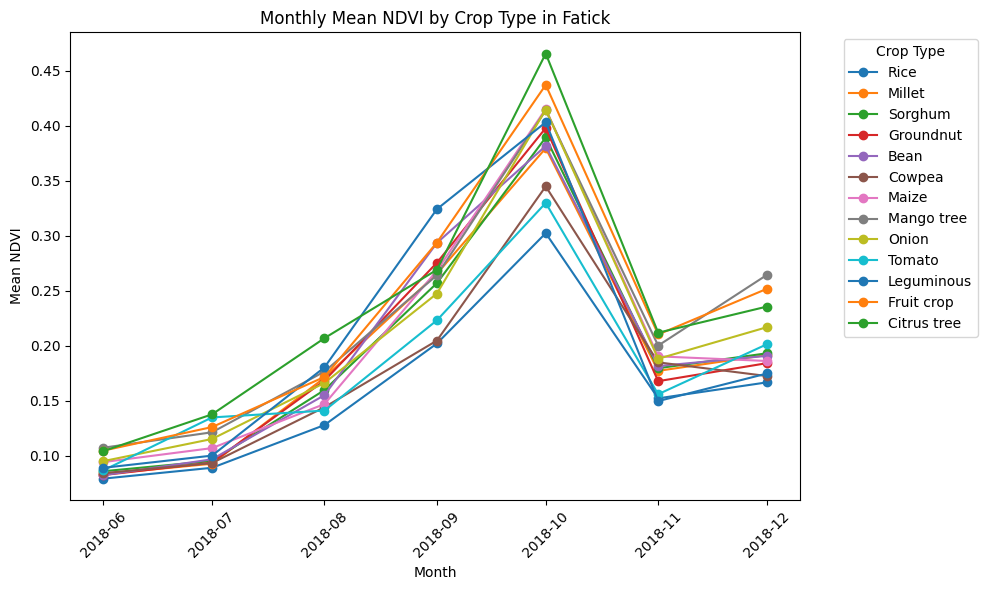

Monthly NDVI plot for all crops in Fatick displayed.

--------------------------------------------------

Processing Admin1 region: Thies
Crops in this region: ['Millet', 'Sorghum', 'Groundnut', 'Eggplant', 'Sweet potato', 'Potato', 'Tomato', 'Citrus tree', 'Fruit crop', 'Leguminous', 'Mango tree', 'Cowpea', 'Cassava', 'Cabbage', 'Bean']


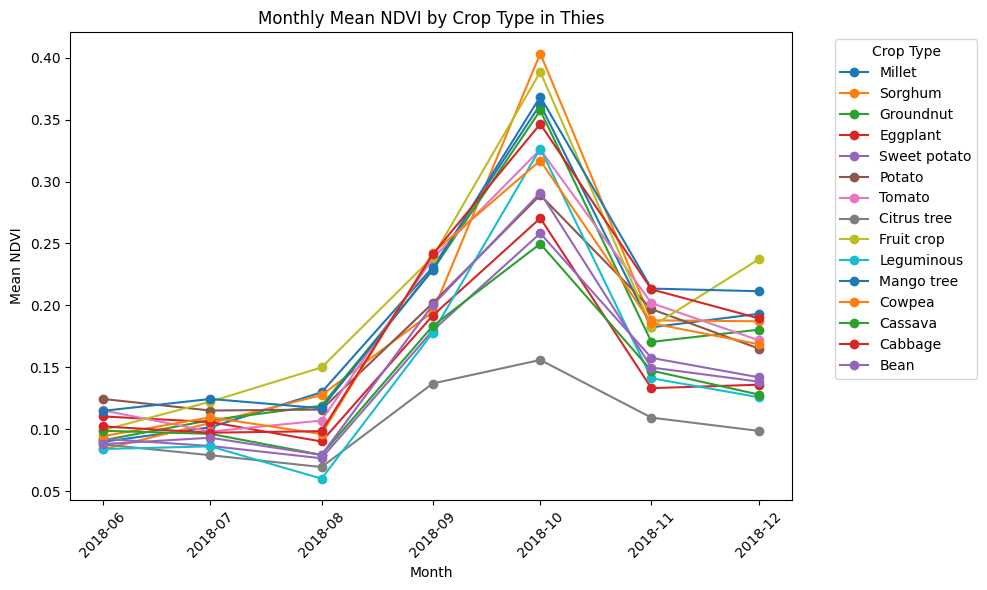

Monthly NDVI plot for all crops in Thies displayed.

--------------------------------------------------

Processing Admin1 region: Tambacounda
Crops in this region: ['Maize', 'Mango tree', 'Cotton', 'Cowpea', 'Millet', 'Sorghum', 'Groundnut', 'Cassava', 'Citrus tree', 'Cabbage']


Error occurred. Retrying in 1 seconds...


Error occurred. Retrying in 2 seconds...


Error occurred. Retrying in 4 seconds...


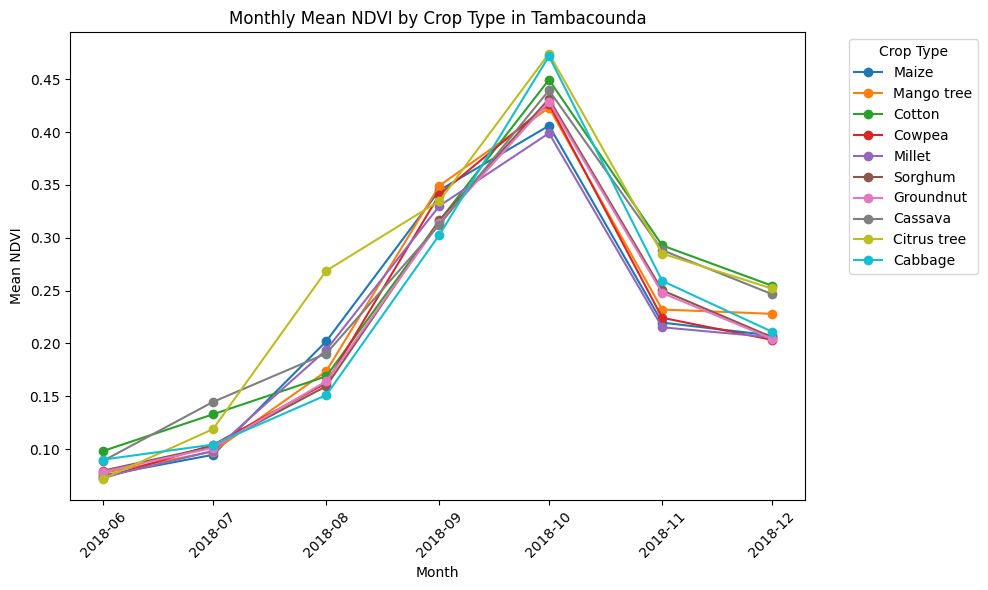

Monthly NDVI plot for all crops in Tambacounda displayed.

--------------------------------------------------

Processing Admin1 region: Diourbel
Crops in this region: ['Cowpea', 'Millet', 'Sorghum', 'Groundnut']


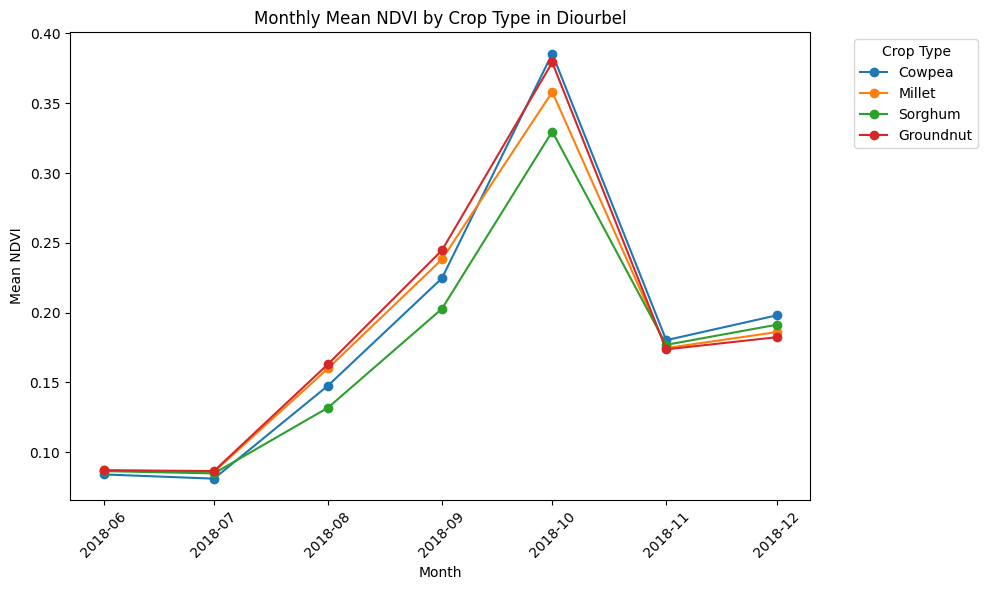

Monthly NDVI plot for all crops in Diourbel displayed.

--------------------------------------------------

Processing Admin1 region: Kaolack
Crops in this region: ['Maize', 'Millet', 'Groundnut', 'Watermelon', 'Sesame']


Error occurred. Retrying in 1 seconds...


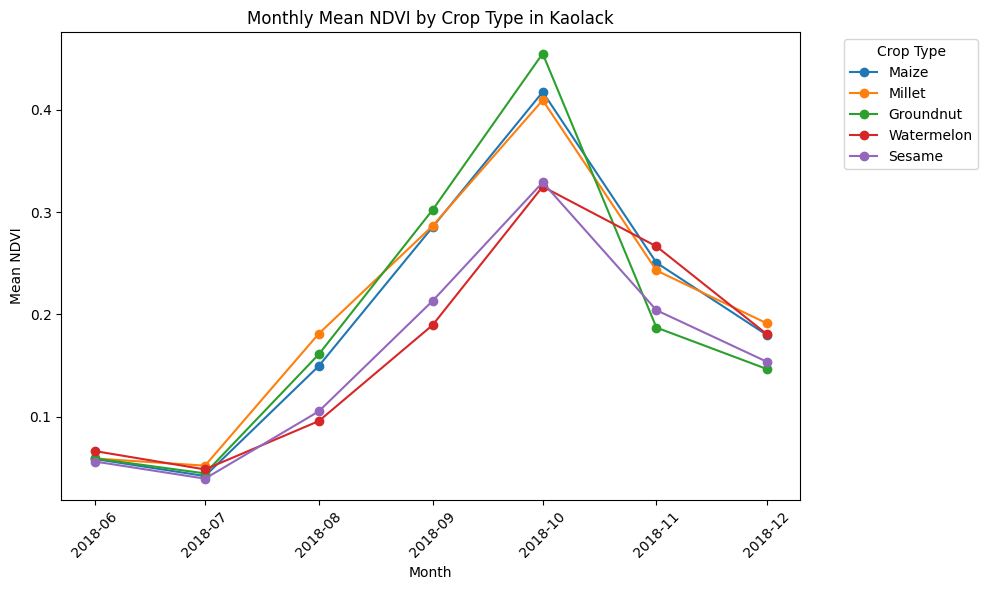

Monthly NDVI plot for all crops in Kaolack displayed.

--------------------------------------------------

Processing complete. All plots have been displayed.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ee
import time

# Ensure Earth Engine is initialized
ee.Initialize()

# Function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Function to safely execute Earth Engine operations with retries
def ee_safe_execute(func, max_retries=5, initial_wait=1):
    for attempt in range(max_retries):
        try:
            return func()
        except Exception as e:
            if attempt == max_retries - 1:
                raise e
            wait_time = initial_wait * (2 ** attempt)
            print(f"Error occurred. Retrying in {wait_time} seconds...")
            time.sleep(wait_time)

# Loop through each Admin1 region
for admin1 in unique_admin1:
    print(f"Processing Admin1 region: {admin1}")

    # Filter data_2018 for the current Admin1 region
    current_data = data_2018.filter(ee.Filter.eq('Admin1', admin1))

    # Get unique crops in this Admin1 region
    crops = ee_safe_execute(lambda: current_data.aggregate_array('Speculatio').distinct().getInfo())
    crops = [crop for crop in crops if crop != '']  # Remove empty crop names
    print(f"Crops in this region: {crops}")

    try:
        # Load Sentinel-2 imagery and filter by date and bounds of the polygons
        sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
            .filterBounds(current_data) \
            .filterDate('2018-06-01', '2018-12-31') \
            .map(calculate_ndvi)

        # Function to calculate mean NDVI for all crop types in an image
        def calculate_mean_ndvi_all_crops(image):
            def crop_ndvi(crop):
                crop_data = current_data.filter(ee.Filter.eq('Speculatio', crop))
                mean = image.select('NDVI').reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=crop_data.geometry(),
                    scale=10,
                    maxPixels=1e9
                )
                return ee.Feature(None, {
                    'crop': crop,
                    'mean_ndvi': mean.get('NDVI'),
                    'date': image.date().format('YYYY-MM-dd')
                })

            return ee.FeatureCollection(ee.List(crops).map(lambda crop: crop_ndvi(crop)))

        # Calculate mean NDVI for each image and crop
        ndvi_time_series = sentinel2.map(calculate_mean_ndvi_all_crops).flatten()

        # Get the time series data
        time_series_data = ee_safe_execute(lambda: ndvi_time_series.getInfo())

        # Convert to pandas DataFrame
        df_list = []
        for feature in time_series_data['features']:
            props = feature['properties']
            if 'mean_ndvi' in props and props['mean_ndvi'] is not None:
                df_list.append({
                    'date': props['date'],
                    'crop': props['crop'],
                    'mean_ndvi': props['mean_ndvi']
                })

        if not df_list:
            print(f"No valid NDVI data found for {admin1}")
            continue

        df_time_series = pd.DataFrame(df_list)
        df_time_series['date'] = pd.to_datetime(df_time_series['date'])

        # Perform temporal aggregation (monthly average)
        df_time_series['month'] = df_time_series['date'].dt.to_period('M')
        df_monthly = df_time_series.groupby(['month', 'crop'])['mean_ndvi'].mean().reset_index()
        df_monthly['month'] = df_monthly['month'].dt.to_timestamp()

        # Create a line plot for all crops
        plt.figure(figsize=(10, 6))

        for crop in crops:
            crop_data = df_monthly[df_monthly['crop'] == crop]
            if not crop_data.empty:
                plt.plot(crop_data['month'], crop_data['mean_ndvi'], marker='o', label=crop)

        plt.title(f'Monthly Mean NDVI by Crop Type in {admin1}')
        plt.xlabel('Month')
        plt.ylabel('Mean NDVI')
        plt.xticks(rotation=45)
        plt.legend(title='Crop Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        print(f"Monthly NDVI plot for all crops in {admin1} displayed.")

    except Exception as e:
        print(f"An error occurred for {admin1}: {str(e)}")
        print("Skipping this region and continuing with the next.")

    print("\n" + "-"*50 + "\n")

print("Processing complete. All plots have been displayed.")

In [ ]:
# Define your polygon asset (replace with your asset path)
#crop_polygons = ee.FeatureCollection("users/your_username/your_asset_name")

# Function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Load Sentinel-2 imagery and filter by date and bounds of the polygons
sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(Fatick) \
    .filterDate('2018-08-01', '2018-09-28') \
    .map(calculate_ndvi)

# Select bands to use for classification
bands = ['B2', 'B3', 'B4', 'B8', 'NDVI']

# Reduce the image collection to median to get a single composite image
image = sentinel2.median().select(bands)

# Sample the image at the points of the polygons and include the 'class' property
training = image.sampleRegions(
    collection=Fatick,
    properties=['Speculatio'],  # Specify the target column or CLASS, e.g Speculatio (Crop Type)
    scale=10
)#.limit(4000) # limited data to perform with Colab

# Convert the sampled data to a Pandas DataFrame
def ee_to_pandas(fc):
    features = fc.getInfo()['features']
    dict_list = []
    for f in features:
        props = f['properties']
        dict_list.append(props)
    return pd.DataFrame(dict_list)

# Convert the training feature collection to a Pandas DataFrame
df = ee_to_pandas(training)

# Check the DataFrame
print(df.head())

# Select the feature columns (X) and the target column (y)
X = df[bands].values
y = df['Speculatio'].values

print("Features: ", X)
print("Labels: ", y)

# Split into training and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

# SVM Classifier
svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

# Evaluate the classifiers
print("Random Forest Classifier Report")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_rf))

print("SVM Classifier Report")
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_svm))




In [ ]:
# Get unique Admin1 regions
admin_properties = data_2018.aggregate_array('Admin1').distinct()
unique_admin1 = admin_properties.getInfo()

print("Unique Admin1 regions:", unique_admin1)
print("\n" + "="*50 + "\n")

# Function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Convert the sampled data to a Pandas DataFrame
def ee_to_pandas(fc):
    features = fc.getInfo()['features']
    dict_list = []
    for f in features:
        props = f['properties']
        dict_list.append(props)
    return pd.DataFrame(dict_list)

# Loop through each Admin1 region
for admin1 in unique_admin1:
    print(f"Processing Admin1 region: {admin1}")

    # Filter data_2018 for the current Admin1 region
    current_data = data_2018.filter(ee.Filter.eq('Admin1', admin1))

    # Get the size (number of features) for this Admin1 region
    region_size = current_data.size().getInfo()
    print(f"Number of features in this region: {region_size}")

    # Get unique crops in this Admin1 region
    crops = current_data.aggregate_array('Speculatio').distinct().getInfo()
    print(f"Crops in this region: {crops}")

    try:
        # Load Sentinel-2 imagery and filter by date and bounds of the polygons
        sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
            .filterBounds(current_data) \
            .filterDate('2018-08-01', '2018-09-28') \
            .map(calculate_ndvi)

        # Select bands to use for classification
        bands = ['B2', 'B3', 'B4', 'B8', 'NDVI']

        # Reduce the image collection to median to get a single composite image
        image = sentinel2.median().select(bands)

        # Sample the image at the points of the polygons and include the 'class' property
        training = image.sampleRegions(
            collection=current_data,
            properties=['Speculatio'],
            scale=10
        )

        # Convert the training feature collection to a Pandas DataFrame
        df = ee_to_pandas(training)

        # Check the DataFrame
        print(df.head())

        # Select the feature columns (X) and the target column (y)
        X = df[bands].values
        y = df['Speculatio'].values

        # Normalize the bands
        scaler = MinMaxScaler()
        X_normalized = scaler.fit_transform(X)

        print("Features shape: ", X_normalized.shape)
        print("Labels shape: ", y.shape)

        # Split into training and validation datasets
        X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

        # Random Forest Classifier
        rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_clf.fit(X_train, y_train)
        y_pred_rf = rf_clf.predict(X_test)

        # SVM Classifier
        svm_clf = SVC(kernel='linear', random_state=42)
        svm_clf.fit(X_train, y_train)
        y_pred_svm = svm_clf.predict(X_test)

        # Evaluate the classifiers
        print("Random Forest Classifier Report")
        print(classification_report(y_test, y_pred_rf))
        print("Confusion Matrix")
        print(confusion_matrix(y_test, y_pred_rf))

        print("SVM Classifier Report")
        print(classification_report(y_test, y_pred_svm))
        print("Confusion Matrix")
        print(confusion_matrix(y_test, y_pred_svm))

    except Exception as e:
        print(f"An error occurred for {admin1}: {str(e)}")
        print("Skipping this region and continuing with the next.")

    print("\n" + "-"*50 + "\n")

print("Processing complete.")

Unique Admin1 regions: ['Fatick', 'Thies', 'Tambacounda', 'Diourbel', 'Kaolack']


Processing Admin1 region: Fatick
Number of features in this region: 1551
Crops in this region: ['Rice', 'Millet', 'Sorghum', 'Groundnut', 'Bean', '', 'Cowpea', 'Maize', 'Mango tree', 'Onion', 'Tomato', 'Leguminous', 'Fruit crop', 'Citrus tree']
An error occurred for Fatick: Collection query aborted after accumulating over 5000 elements.
Skipping this region and continuing with the next.

--------------------------------------------------

Processing Admin1 region: Thies
Number of features in this region: 784
Crops in this region: ['Millet', 'Sorghum', 'Groundnut', '', 'Eggplant', 'Sweet potato', 'Potato', 'Tomato', 'Citrus tree', 'Fruit crop', 'Leguminous', 'Mango tree', 'Cowpea', 'Cassava', 'Cabbage', 'Bean']
An error occurred for Thies: Collection query aborted after accumulating over 5000 elements.
Skipping this region and continuing with the next.

--------------------------------------------------



In [ ]:
# Get unique Admin1 regions
admin_properties = data_2018.aggregate_array('Admin1').distinct()
unique_admin1 = admin_properties.getInfo()

print("Unique Admin1 regions:", unique_admin1)
print("\n" + "="*50 + "\n")

# Function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Convert the sampled data to a Pandas DataFrame
def ee_to_pandas(fc):
    features = fc.getInfo()['features']
    dict_list = []
    for f in features:
        props = f['properties']
        dict_list.append(props)
    return pd.DataFrame(dict_list)

# Loop through each Admin1 region
for admin1 in unique_admin1:
    print(f"Processing Admin1 region: {admin1}")

    # Filter data_2018 for the current Admin1 region
    current_data = data_2018.filter(ee.Filter.eq('Admin1', admin1))

    # Get the size (number of features) for this Admin1 region
    region_size = current_data.size().getInfo()
    print(f"Number of features in this region: {region_size}")

    # Get unique crops in this Admin1 region
    crops = current_data.aggregate_array('Speculatio').distinct().getInfo()
    print(f"Crops in this region: {crops}")

    try:
        # Load Sentinel-2 imagery and filter by date and bounds of the polygons
        sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
            .filterBounds(current_data) \
            .filterDate('2018-08-01', '2018-09-28') \
            .map(calculate_ndvi)

        # Select bands to use for classification
        bands = ['B2', 'B3', 'B4', 'B8', 'NDVI']

        # Reduce the image collection to median to get a single composite image
        image = sentinel2.median().select(bands)

        # Sample the image at the points of the polygons and include the 'class' property
        training = image.sampleRegions(
            collection=current_data,
            properties=['Speculatio'],
            scale=10
        )

        # Convert the training feature collection to a Pandas DataFrame
        df = ee_to_pandas(training)

        # Check the DataFrame
        print(df.head())

        # Select the feature columns (X) and the target column (y)
        X = df[bands].values
        y = df['Speculatio'].values

        # Normalize the bands
        scaler = MinMaxScaler()
        X_normalized = scaler.fit_transform(X)

        print("Features shape: ", X_normalized.shape)
        print("Labels shape: ", y.shape)

        # Split into training and validation datasets
        X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

        # Random Forest Classifier
        rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_clf.fit(X_train, y_train)
        y_pred_rf = rf_clf.predict(X_test)

        # SVM Classifier
        svm_clf = SVC(kernel='linear', random_state=42)
        svm_clf.fit(X_train, y_train)
        y_pred_svm = svm_clf.predict(X_test)

        # Evaluate the classifiers
        print("Random Forest Classifier Report")
        print(classification_report(y_test, y_pred_rf))
        print("Confusion Matrix")
        print(confusion_matrix(y_test, y_pred_rf))

        print("SVM Classifier Report")
        print(classification_report(y_test, y_pred_svm))
        print("Confusion Matrix")
        print(confusion_matrix(y_test, y_pred_svm))

    except Exception as e:
        print(f"An error occurred for {admin1}: {str(e)}")
        print("Skipping this region and continuing with the next.")

    print("\n" + "-"*50 + "\n")

print("Processing complete.")

In [ ]:
#second way


def print_results(admin1, region_size, crops, df, X_shape, y_shape, rf_report, rf_matrix, svm_report, svm_matrix):
    print("\n" + "="*50)
    print(f"Results for Admin1 region: {admin1}")
    print("="*50)

    print(f"Number of features in this region: {region_size}")
    print(f"Crops in this region: {', '.join(crops)}")

    print("\nSample data:")
    print(df.head().to_string())

    print(f"\nFeatures shape: {X_shape}")
    print(f"Labels shape: {y_shape}")

    print("\nRandom Forest Classifier Report")
    print(rf_report)
    print("Confusion Matrix")
    print(rf_matrix)

    print("\nSVM Classifier Report")
    print(svm_report)
    print("Confusion Matrix")
    print(svm_matrix)

# Function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Convert the sampled data to a Pandas DataFrame
def ee_to_pandas(fc):
    features = fc.getInfo()['features']
    dict_list = []
    for f in features:
        props = f['properties']
        dict_list.append(props)
    return pd.DataFrame(dict_list)

# Get unique Admin1 regions
admin_properties = data_2018.aggregate_array('Admin2').distinct()
unique_admin1 = admin_properties.getInfo()

print("Unique Admin1 regions:", ', '.join(unique_admin1))
print("\n" + "="*50 + "\n")

# Loop through each Admin1 region
for admin1 in unique_admin1:
    print(f"Processing Admin1 region: {admin1}")

    # Filter data_2018 for the current Admin1 region
    current_data = data_2018.filter(ee.Filter.eq('Admin2', admin1))

    # Get the size (number of features) for this Admin1 region
    region_size = current_data.size().getInfo()
    print(f"Number of features in this region: {region_size}")

    # Get unique crops in this Admin1 region
    crops = current_data.aggregate_array('Speculatio').distinct().getInfo()
    print(f"Crops in this region: {', '.join(crops)}")

    try:
        # Load Sentinel-2 imagery and filter by date and bounds of the polygons
        sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
            .filterBounds(current_data) \
            .filterDate('2018-08-01', '2018-09-28')

        # Check if the image collection is empty
        image_count = sentinel2.size().getInfo()
        if image_count == 0:
            print(f"No Sentinel-2 images found for {admin1} in the specified date range.")
            continue

        print(f"Number of Sentinel-2 images found: {image_count}")

        # Apply NDVI calculation
        sentinel2 = sentinel2.map(calculate_ndvi)

        # Select bands to use for classification
        bands = ['B2', 'B3', 'B4', 'B8', 'NDVI']

        # Reduce the image collection to median to get a single composite image
        image = sentinel2.median().select(bands)

        # Sample the image at the points of the polygons and include the 'class' property
        training = image.sampleRegions(
            collection=current_data,
            properties=['Speculatio'],
            scale=10
        )

        # Convert the training feature collection to a Pandas DataFrame
        df = ee_to_pandas(training)

        # Check if the DataFrame is empty
        if df.empty:
            print(f"No data sampled for {admin1}. Skipping this region.")
            continue

        # Select the feature columns (X) and the target column (y)
        X = df[bands].values
        y = df['Speculatio'].values

        # Normalize the bands
        scaler = MinMaxScaler()
        X_normalized = scaler.fit_transform(X)

        # Split into training and validation datasets
        X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

        # Random Forest Classifier
        rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_clf.fit(X_train, y_train)
        y_pred_rf = rf_clf.predict(X_test)

        # SVM Classifier
        svm_clf = SVC(kernel='linear', random_state=42)
        svm_clf.fit(X_train, y_train)
        y_pred_svm = svm_clf.predict(X_test)

        # Generate reports
        rf_report = classification_report(y_test, y_pred_rf)
        rf_matrix = confusion_matrix(y_test, y_pred_rf)
        svm_report = classification_report(y_test, y_pred_svm)
        svm_matrix = confusion_matrix(y_test, y_pred_svm)

        # Print results
        print_results(admin1, region_size, crops, df, X_normalized.shape, y.shape,
                      rf_report, rf_matrix, svm_report, svm_matrix)

    except Exception as e:
        print(f"An error occurred for {admin1}: {str(e)}")
        print("Skipping this region and continuing with the next.")

    print("\n" + "-"*50 + "\n")

print("Processing complete.")

Unique Admin1 regions: Fatick, Mbour, Tambacounda, Tivaouane, Bambey, Nioro du Rip


Processing Admin1 region: Fatick
Number of features in this region: 1551
Crops in this region: Rice, Millet, Sorghum, Groundnut, Bean, , Cowpea, Maize, Mango tree, Onion, Tomato, Leguminous, Fruit crop, Citrus tree
Number of Sentinel-2 images found: 25
An error occurred for Fatick: Collection query aborted after accumulating over 5000 elements.
Skipping this region and continuing with the next.

--------------------------------------------------

Processing Admin1 region: Mbour
Number of features in this region: 23
Crops in this region: Millet, Sorghum, Groundnut, , Fruit crop
Number of Sentinel-2 images found: 25

Results for Admin1 region: Mbour
Number of features in this region: 23
Crops in this region: Millet, Sorghum, Groundnut, , Fruit crop

Sample data:
       B2      B3      B4      B8      NDVI Speculatio
0  1985.0  2082.0  2238.0  3447.0  0.152785     Millet
1  2068.0  2152.0  2236.0  3461.0 

In [ ]:
# Function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Convert the sampled data to a Pandas DataFrame
def ee_to_pandas(fc):
    features = fc.getInfo()['features']
    dict_list = []
    for f in features:
        props = f['properties']
        dict_list.append(props)
    return pd.DataFrame(dict_list)

# Loop through each Admin1 region
for admin1 in unique_admin1:
    print(f"Processing Admin1 region: {admin1}")

    # Filter data_2018 for the current Admin1 region
    current_data = data_2018.filter(ee.Filter.eq('Admin1', admin1))

    # Get unique crops in this Admin1 region
    crops = current_data.aggregate_array('Speculatio').distinct().getInfo()
    print(f"Crops in this region: {crops}")

    try:
        # Load Sentinel-2 imagery and filter by date and bounds of the polygons
        sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
            .filterBounds(current_data) \
            .filterDate('2018-08-01', '2018-09-28') \
            .map(calculate_ndvi)

        # Reduce the image collection to median to get a single composite image
        image = sentinel2.median().clip(current_data).select('NDVI')

        # Sample the image at the points of the polygons and include the 'Speculatio' property
        sampled_data = image.sampleRegions(
            collection=current_data,
            properties=['Speculatio'],
            scale=10
        )

        # Convert to pandas DataFrame
        df = ee_to_pandas(sampled_data)

        # Calculate mean NDVI for each crop
        ndvi_means = df.groupby('Speculatio')['NDVI'].mean().reset_index()

        # Create a bar plot
        plt.figure(figsize=(12, 6))
        plt.bar(ndvi_means['Speculatio'], ndvi_means['NDVI'])
        plt.title(f'Mean NDVI by Crop Type in {admin1}')
        plt.xlabel('Crop Type')
        plt.ylabel('Mean NDVI')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f'NDVI_plot_{admin1.replace(" ", "_")}.png')
        plt.close()

        print(f"NDVI plot for {admin1} saved.")

    except Exception as e:
        print(f"An error occurred for {admin1}: {str(e)}")
        print("Skipping this region and continuing with the next.")

    print("\n" + "-"*50 + "\n")

print("Processing complete.")

Processing Admin1 region: Fatick
Crops in this region: ['Rice', 'Millet', 'Sorghum', 'Groundnut', 'Bean', '', 'Cowpea', 'Maize', 'Mango tree', 'Onion', 'Tomato', 'Leguminous', 'Fruit crop', 'Citrus tree']
An error occurred for Fatick: Collection query aborted after accumulating over 5000 elements.
Skipping this region and continuing with the next.

--------------------------------------------------

Processing Admin1 region: Thies
Crops in this region: ['Millet', 'Sorghum', 'Groundnut', '', 'Eggplant', 'Sweet potato', 'Potato', 'Tomato', 'Citrus tree', 'Fruit crop', 'Leguminous', 'Mango tree', 'Cowpea', 'Cassava', 'Cabbage', 'Bean']
An error occurred for Thies: Collection query aborted after accumulating over 5000 elements.
Skipping this region and continuing with the next.

--------------------------------------------------

Processing Admin1 region: Tambacounda
Crops in this region: ['', 'Maize', 'Mango tree', 'Cotton', 'Cowpea', 'Millet', 'Sorghum', 'Groundnut', 'Cassava', 'Citrus t

visualize

In [ ]:

# Function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Function to add Earth Engine layer to Folium map
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Loop through each Admin1 region
for admin1 in unique_admin1:
    print(f"Processing Admin1 region: {admin1}")

    # Filter data_2018 for the current Admin1 region
    current_data = data_2018.filter(ee.Filter.eq('Admin1', admin1))

    # Get unique crops in this Admin1 region
    crops = current_data.aggregate_array('Speculatio').distinct().getInfo()
    print(f"Crops in this region: {crops}")

    try:
        # Load Sentinel-2 imagery and filter by date and bounds of the polygons
        sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
            .filterBounds(current_data) \
            .filterDate('2018-08-01', '2018-09-28') \
            .map(calculate_ndvi)

        # Reduce the image collection to median to get a single composite image
        image = sentinel2.median().clip(current_data).select('NDVI')

        # Use reduceRegions to calculate mean NDVI for each feature
        reduced = image.reduceRegions(
            collection=current_data,
            reducer=ee.Reducer.mean(),
            scale=10,
            tileScale=16
        )

        # Get the results as a list of dictionaries
        result_list = reduced.getInfo()['features']

        # Convert to pandas DataFrame
        df = pd.DataFrame([
            {**f['properties'], 'geometry': f['geometry']}
            for f in result_list
        ])

        # Calculate mean NDVI for each crop
        ndvi_means = df.groupby('Speculatio')['mean'].mean().reset_index()
        ndvi_means = ndvi_means[ndvi_means['Speculatio'] != '']  # Remove empty crop names

        # Create a bar plot
        plt.figure(figsize=(12, 6))
        plt.bar(ndvi_means['Speculatio'], ndvi_means['mean'])
        plt.title(f'Mean NDVI by Crop Type in {admin1}')
        plt.xlabel('Crop Type')
        plt.ylabel('Mean NDVI')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f'NDVI_plot_{admin1.replace(" ", "_")}.png')
        plt.close()

        print(f"NDVI plot for {admin1} saved.")

        # Create Folium map
        region_center = current_data.geometry().centroid().getInfo()['coordinates']
        map_center = [region_center[1], region_center[0]]  # Folium uses [lat, lon]

        m = folium.Map(location=map_center, zoom_start=8)

        # Add NDVI layer to the map
        vis_params = {'min': 0, 'max': 1, 'palette': ['red', 'yellow', 'green']}
        m.add_ee_layer(image, vis_params, 'NDVI')

        # Add layer control and save map
        folium.LayerControl().add_to(m)
        m.save(f'NDVI_map_{admin1.replace(" ", "_")}.html')

        print(f"NDVI map for {admin1} saved.")

    except Exception as e:
        print(f"An error occurred for {admin1}: {str(e)}")
        print("Skipping this region and continuing with the next.")

    print("\n" + "-"*50 + "\n")

print("Processing complete.")

Processing Admin1 region: Fatick
Crops in this region: ['Rice', 'Millet', 'Sorghum', 'Groundnut', 'Bean', '', 'Cowpea', 'Maize', 'Mango tree', 'Onion', 'Tomato', 'Leguminous', 'Fruit crop', 'Citrus tree']
NDVI plot for Fatick saved.
NDVI map for Fatick saved.

--------------------------------------------------

Processing Admin1 region: Thies
Crops in this region: ['Millet', 'Sorghum', 'Groundnut', '', 'Eggplant', 'Sweet potato', 'Potato', 'Tomato', 'Citrus tree', 'Fruit crop', 'Leguminous', 'Mango tree', 'Cowpea', 'Cassava', 'Cabbage', 'Bean']
NDVI plot for Thies saved.
NDVI map for Thies saved.

--------------------------------------------------

Processing Admin1 region: Tambacounda
Crops in this region: ['', 'Maize', 'Mango tree', 'Cotton', 'Cowpea', 'Millet', 'Sorghum', 'Groundnut', 'Cassava', 'Citrus tree', 'Cabbage']
NDVI plot for Tambacounda saved.
NDVI map for Tambacounda saved.

--------------------------------------------------

Processing Admin1 region: Diourbel
Crops in th

In [ ]:
# Define non-crop categories
non_crop_categories = ['Built_up', 'Route bitumee', 'Laterite_road', 'Sandy_road', 'Piste', 'Sol nu']

# Function to classify crop/non-crop
def classify_crop_type(feature):
    speculatio = ee.Algorithms.If(
        feature.propertyNames().contains('Speculatio'),
        ee.String(feature.get('Speculatio')),
        ee.String('Unknown')
    )
    is_non_crop = ee.List(non_crop_categories).contains(speculatio)
    return feature.set('Crop_Ncrop', ee.Algorithms.If(is_non_crop, 'Non-crop', 'Crop'))

# Apply the classification
updated_data_2020 = data_2020.map(classify_crop_type)

# Get the first 1000 features (adjust this number based on your needs and system capabilities)
features_to_display = updated_data_2020.limit(1000).getInfo()['features']

# Extract properties into a list of dictionaries
properties_list = [feature['properties'] for feature in features_to_display]

# Create a DataFrame from the properties list
df = pd.DataFrame(properties_list)
df.tail()